In [1]:
import librosa
import librosa.display

import matplotlib 
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import IPython.display as ipd

from scipy.fft import fft

import numpy as np

from andatum_rene_sandbox import andatum as adt

import sounddevice as sd

In [2]:
song = adt("../data/external/Ralf Reuvers - Andata.wav")

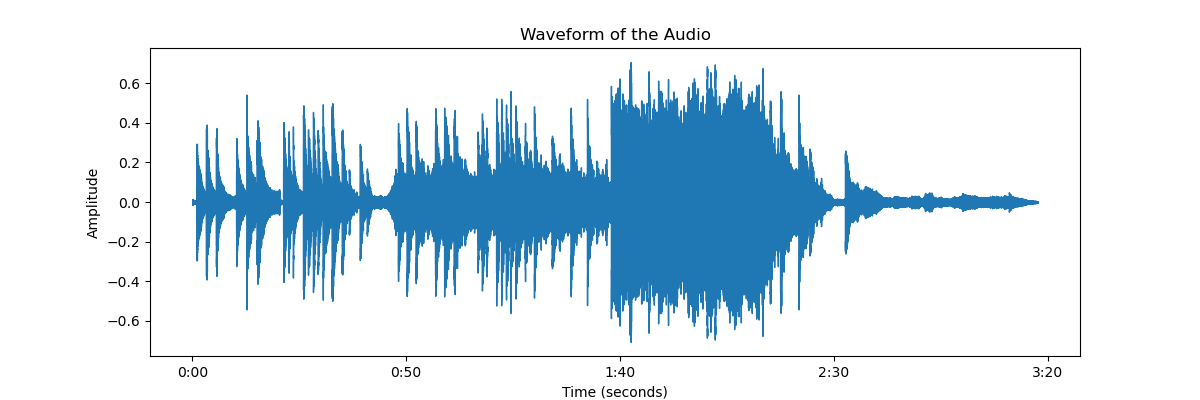

In [3]:
# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(song.tseries, sr=song.sr)
plt.title("Waveform of the Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [32]:
# ipd.Audio(song.filepath)

In [5]:
# Compute FFT of the entire signal
fft_spectrum = np.abs(fft(song.tseries))

# Get frequencies
freqs = np.fft.fftfreq(len(fft_spectrum), 1/song.sr)

In [6]:
# Keep only positive frequencies
positive_freqs = freqs[:len(freqs)//2]
positive_fft_spectrum = fft_spectrum[:len(freqs)//2]

In [7]:
# Compute total energy
total_energy = np.sum(positive_fft_spectrum)

# Compute cumulative energy distribution
sorted_magnitudes = np.sort(positive_fft_spectrum)[::-1]  # Sort in descending order
cumulative_energy = np.cumsum(sorted_magnitudes) / total_energy  # Normalize

# Find frequency cutoff where 95% of the energy is retained
threshold = 0.95  # 95% energy threshold
cutoff_index = np.argmax(cumulative_energy >= threshold)

# Get the corresponding frequency range
important_freq_range = positive_freqs[:cutoff_index]

print(f"Important frequency range: 0 - {important_freq_range[-1]:.2f} Hz")

Important frequency range: 0 - 3479.46 Hz


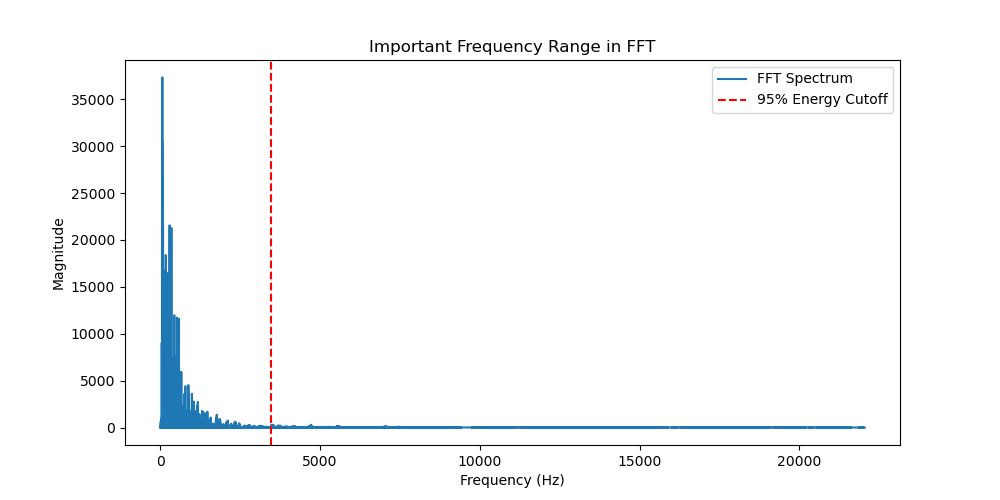

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, positive_fft_spectrum, label="FFT Spectrum")
plt.axvline(important_freq_range[-1], color="red", linestyle="--", label="95% Energy Cutoff")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Important Frequency Range in FFT")
plt.legend()
plt.show()

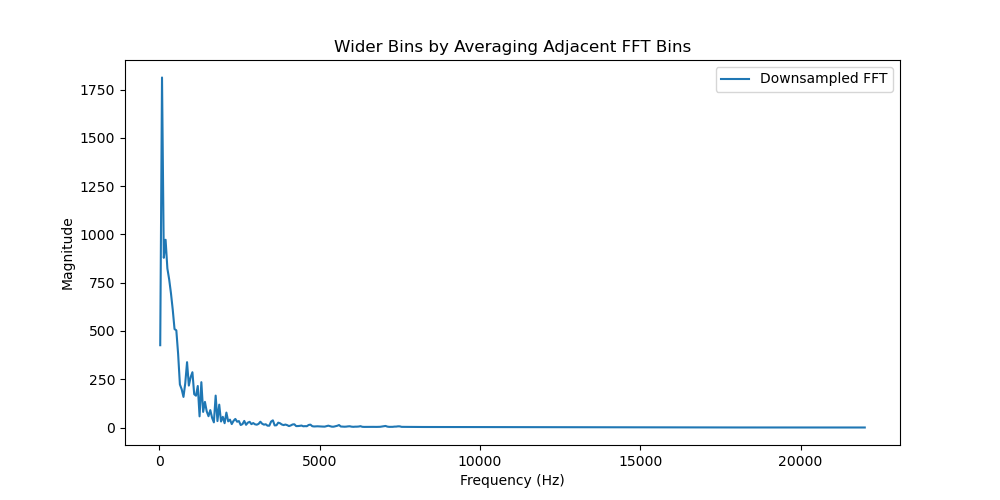

In [9]:
import numpy as np

# Define bin width (e.g., group every 10 bins into one)
bin_width = 11025

# Ensure the length of positive_freqs is a multiple of bin_width
trim_length = len(freqs[:len(freqs)//2]) // bin_width * bin_width
positive_freqs = freqs[:trim_length].reshape(-1, bin_width).mean(axis=1)
positive_fft_spectrum = fft_spectrum[:trim_length].reshape(-1, bin_width).mean(axis=1)

# Plot the downsampled spectrum
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, positive_fft_spectrum, label="Downsampled FFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Wider Bins by Averaging Adjacent FFT Bins")
plt.legend()
plt.show()

In [10]:
import numpy as np

# Find indices of the most dominant frequencies
top_n = 5  # Number of top frequencies to extract
top_indices = np.argsort(positive_fft_spectrum)[-top_n:]  # Indices of top N peaks

# Extract the corresponding frequencies and magnitudes
top_frequencies = positive_freqs[top_indices]
top_magnitudes = positive_fft_spectrum[top_indices]

# Print results
for f, mag in zip(top_frequencies, top_magnitudes):
    print(f"Frequency: {f:.2f} Hz, Magnitude: {mag:.2f}")

Frequency: 306.75 Hz, Magnitude: 766.97
Frequency: 250.98 Hz, Magnitude: 823.42
Frequency: 139.43 Hz, Magnitude: 878.82
Frequency: 195.20 Hz, Magnitude: 972.25
Frequency: 83.66 Hz, Magnitude: 1812.54


In [11]:
print(song.sr/4)

11025.0


**For a Soothing Experience**
- Combine frequencies in the 20 Hz – 200 Hz range for visually smooth and musically calming effects.
- Use harmonic relationships (e.g., 50 Hz + 100 Hz + 150 Hz) to create aesthetically pleasing beats and wave interference patterns.
- Apply a slight amplitude modulation or phase shift to create visually dynamic and organic motion.

Resampling from 44100 Hz to 48000.0 Hz
48000.0


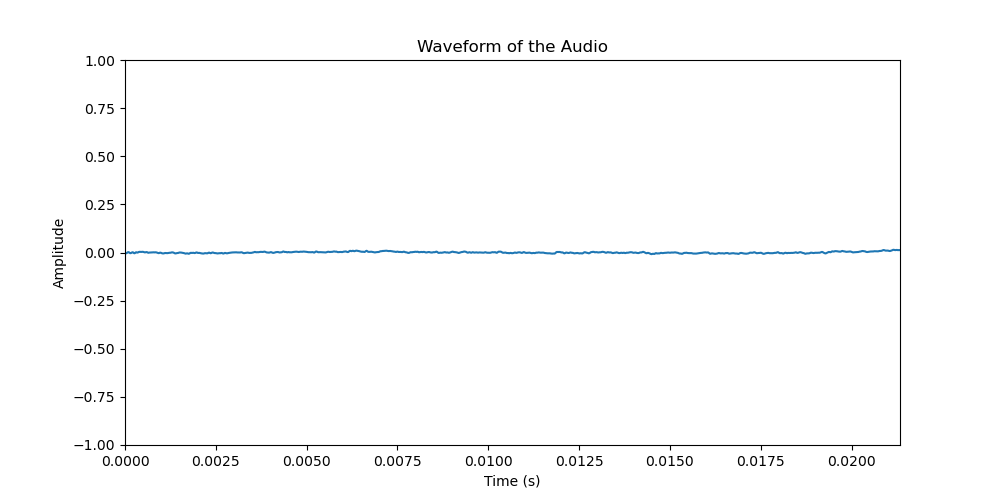

In [28]:
song = adt("../data/external/Ralf Reuvers - Andata.wav")

# Check if the sample rate is supported
output_device_info = sd.query_devices(sd.default.device['output'], 'output')
supported_sample_rate = output_device_info['default_samplerate']

if song.sr != supported_sample_rate:
    print(f"Resampling from {song.sr} Hz to {supported_sample_rate} Hz")
    song.tseries = librosa.resample(song.tseries, orig_sr=song.sr, target_sr=supported_sample_rate)
    song.sr = supported_sample_rate
    print(song.sr)

# Function to play audio
def play_audio(data, sample_rate):
    sd.play(data, sample_rate)

# Function to update the plot
def update_plot(frame):
    global start_idx
    end_idx = start_idx + window_size
    if end_idx > len(song.tseries):
        end_idx = len(song.tseries)
    line.set_ydata(song.tseries[start_idx:end_idx])
    start_idx += hop_size
    return line,

# Parameters for the dynamic plot
window_size = 1024  # Number of samples to display at a time
hop_size = 512  # Number of samples to advance for each frame
start_idx = 0

song_duration = len(song.tseries) / song.sr  # Duration of the song in seconds
num_frames = len(range(0, len(song.tseries), hop_size))  # Number of frames in the animation
interval = (song_duration / num_frames) * 1000  # Interval in milliseconds

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 5))
time = np.linspace(0, window_size / song.sr, num=window_size)
line, = ax.plot(time, song.tseries[:window_size])
ax.set_xlim(0, window_size / song.sr)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Waveform of the Audio")

# Create the animation
ani = animation.FuncAnimation(fig, update_plot, frames=range(0, len(song.tseries), hop_size), blit=False, interval=interval)

# Play the audio
play_audio(song.tseries, song.sr)

# Show the plot
plt.show()

In [29]:
sd.stop()
ani.event_source.stop()
ani = None

In [30]:
# Calculate the interval value
song_duration = len(song.tseries) / song.sr  # Duration of the song in seconds
num_frames = len(range(0, len(song.tseries), hop_size))  # Number of frames in the animation
interval = (song_duration / num_frames) * 1000  # Interval in milliseconds
print(interval)

10.666151819277324


Make a gif for the animation that corresponds to the song length and play the gif